# 2-Stage Calibrate with SwiGLU

## 导入模型

In [1]:
import numpy as np
# import pandas as pd
import torch.nn.functional as F

import torch 

import sys
sys.path.append('../')
sys.path.append('../../')

# 导入模型
from Networks.nn import NN_pricing_SwiGLU
from Pricing.rBergomi.rBergomi_utils import *
from calibrate_utils import *

# 评估使用 cpu
device = torch.device('cpu')

# 设置参数为 4 个
hyperparams = { 
    'input_dim': 4, 
    'hidden_dim': 64, 
    'hidden_nums': 4,
    'output_dim': 88
}

model = NN_pricing_SwiGLU(hyperparams=hyperparams).to(device=device, dtype=torch.float64)


model_state = torch.load( 
    r'../../Results/models/SwiGLU_rBergomi_flat_forward_variance.pth'
)
model.load_state_dict(model_state)

# 设置为 eval mode
model.eval()
model.to(device=device, dtype=torch.float64)

NN_pricing_SwiGLU(
  (layer_lst): ModuleList(
    (0): SwiGLUBlock(
      (projection): Linear(in_features=4, out_features=64, bias=True)
      (gate): Linear(in_features=4, out_features=64, bias=True)
    )
    (1-3): 3 x SwiGLUBlock(
      (projection): Linear(in_features=64, out_features=64, bias=True)
      (gate): Linear(in_features=64, out_features=64, bias=True)
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (output_layer): Linear(in_features=64, out_features=88, bias=True)
)

## 数据

In [2]:
# 数据集
import gzip
f = gzip.GzipFile(
    filename = r"../../Data/rBergomiTrainSet.txt.gz", 
    mode = "r"
)

data = np.load(f)
xx, yy = data[:, :4], data[:, 4:]

strikes=np.array([0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5 ])
maturities=np.array([0.1,0.3,0.6,0.9,1.2,1.5,1.8,2.0 ])

# xx: 参数
## 前 4 列代表网格所对应的参数
xx = data[:, :4]
print(f"参数形状：{xx.shape}")

# yy: 隐含波动率曲面 
# 后 88 列表示隐含波动率曲面 8 * 11 = 88
yy = data[:, 4:]
print(f"隐含波动率曲面形状：{yy.shape}")

# 参数
print(f"参数上界: {np.max(xx, axis=0)}")
print(f"参数下界: {np.min(xx, axis=0)}")


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import sys
sys.path.append('../')

# from NN_Training.rBergomi_nn_pricer import x_transform, x_inv_transform, y_transform, y_inv_transform, params_scaler, params_inv_scaler


x_train, x_test, y_train, y_test = train_test_split(xx, yy, test_size=0.15, random_state=42)

scale_x, scale_y = StandardScaler(), StandardScaler()


# 工具函数——数据标准化
def x_transform(train_data, test_data): 
    return scale_x.fit_transform(train_data), scale_x.transform(test_data)

def x_inv_transform(x):
    return scale_x.inverse_transform(x)

def y_transform(train_data, test_data): 
    return scale_y.fit_transform(train_data), scale_y.transform(test_data)

def y_inv_transform(y):
    return scale_y.inverse_transform(y)


# 训练集的 Upper and Lower Bounds
upper_bound = np.array([0.16,4,-0.1,0.5])
lower_bound = np.array([0.01,0.3,-0.95,0.025])

def params_scaler(x): 
    return (x - (upper_bound+lower_bound) / 2 ) * 2 / (upper_bound-lower_bound)

def params_inv_scaler(x):
    return x * (upper_bound-lower_bound) / 2 + (upper_bound+lower_bound) / 2


x_train_transform = params_scaler(x_train)
x_test_transform = params_scaler(x_test)

y_train_transform, y_test_transform = y_transform(y_train, y_test)


train_data = (torch.from_numpy(x_train_transform).to(device=device),torch.from_numpy(y_train_transform).to(device=device))

test_data = (torch.from_numpy(x_test_transform).to(device=device),torch.from_numpy(y_test_transform).to(device=device))


print(f"训练集形状：{train_data[0].shape}")
print(f"测试集形状：{test_data[0].shape}")

参数形状：(40000, 4)
隐含波动率曲面形状：(40000, 88)
参数上界: [ 0.16      4.       -0.100011  0.499998]
参数下界: [ 0.0100133  0.300028  -0.949934   0.0250066]
训练集形状：torch.Size([34000, 4])
测试集形状：torch.Size([6000, 4])


## 2 阶段优化

In [8]:
def calibrate_with_better_init(model, market_iv, device):
    """
    改进的校准函数：使用更智能的初始点
    """
    model.eval()
    
    # --- 关键改进1：使用多样化、合理的初始猜测 ---
    # 替代方案A：从参数先验分布中随机采样
    # H ~ Uniform(0.05, 0.15), eta ~ Uniform(1.5, 2.5), rho ~ Uniform(-0.9, -0.5), v0 ~ Uniform(0.02, 0.06)
    # init_params = torch.tensor([
    #     torch.empty(1).uniform_(0.05, 0.15).item(),
    #     torch.empty(1).uniform_(1.5, 2.5).item(),
    #     torch.empty(1).uniform_(-0.9, -0.5).item(),
    #     torch.empty(1).uniform_(0.02, 0.06).item()
    # ], dtype=torch.float64, requires_grad=True, device=device)
    
    # 替代方案B：如果你有训练数据的统计，可以用均值作为初始点
    init_params = torch.tensor([0.1, 2.0, -0.7, 0.04], dtype=torch.float64, requires_grad=True, device=device)
    
    market_iv_tensor = torch.tensor(market_iv, dtype=torch.float64, device=device)
    
    optimizer = torch.optim.LBFGS([init_params], lr=0.5, max_iter=100, 
                                  tolerance_grad=1e-12,  # 设置更严格的梯度容差
                                  tolerance_change=1e-12,
                                  history_size=150, 
                                  line_search_fn='strong_wolfe')
    
    losses = []
    
    def closure():
        optimizer.zero_grad()
        pred = model(init_params.unsqueeze(0)).squeeze(0)
        loss = F.mse_loss(pred, market_iv_tensor)
        loss.backward()
        losses.append(loss.item())
        return loss
    
    # --- 关键改进2：增加最大迭代次数并监控 ---
    max_epochs = 10
    for epoch in range(max_epochs):
        optimizer.step(closure)
        current_loss = losses[-1]
        grad_norm = torch.norm(init_params.grad, dtype=torch.float64).item() if init_params.grad is not None else 0
        
        # print(f"Epoch {epoch+1}: Loss = {current_loss:.6e}, Grad Norm = {grad_norm:.6e}, Params = {init_params.detach().cpu().numpy()}")
        
        # 提前停止条件
        if grad_norm < 1e-9 or current_loss < 1e-7:
            print(f"提前停止：梯度或损失已足够小")
            break
    
    return init_params.detach().cpu().numpy(), losses


def two_stage_calibration(model, market_iv, device, adam_iters=200):
    model.eval()
    params = torch.tensor([0.1, 2.0, -0.7, 0.04], dtype=torch.float64, requires_grad=True, device=device)
    market_iv_tensor = torch.tensor(market_iv, dtype=torch.float64, device=device)
    
    # 第一阶段: Adam粗调（能逃离平坦区）
    # print("=== 第一阶段: Adam粗调 ===")
    optimizer_adam = torch.optim.Adam([params], lr=0.01)
    for i in range(adam_iters):
        optimizer_adam.zero_grad()
        pred = model(params.unsqueeze(0)).squeeze(0)
        loss = F.mse_loss(pred, market_iv_tensor)
        loss.backward()
        optimizer_adam.step()
        
        # if i % 50 == 0:
        #     print(f"  Adam Iter {i}: Loss = {loss.item():.6e}")
    
    # print(f"Adam后参数: {params.detach().cpu().numpy()}")
    
    # 第二阶段: L-BFGS精调
    # print("=== 第二阶段: L-BFGS精调 ===")
    return calibrate_with_better_init(model, market_iv, device)  # 复用上面的函数，以Adam结果作为初始点


y_test_short = y_test_transform[:100]

Approx, Timing = np.zeros((len(y_test_short), 4)), np.zeros(len(y_test_short))

for i in range(len(y_test_short)):
    print(f"{i+1}/{len(y_test_short)}", end="\r")

    start_time = time.time()
    params, losses = two_stage_calibration(model, y_test_short[i], device)
    end_time = time.time()
    Timing[i] = end_time - start_time
    params = params_inv_scaler(params)
    Approx[i] = params


In [11]:
Approx[:10]

array([[ 0.10458155,  0.5708504 , -0.7494144 ,  0.24720025],
       [ 0.1555397 ,  3.37042746, -0.45475366,  0.30057169],
       [ 0.09233449,  1.98150072, -0.6359181 ,  0.14011117],
       [-0.08156386,  7.22189907, -1.39272776,  0.25317704],
       [ 0.0755643 ,  0.69670491, -0.36784841,  0.08708972],
       [ 0.02654873,  3.42512391, -0.76381673,  0.16246116],
       [ 0.15788937,  3.38274804, -0.47501977,  0.26666397],
       [ 0.07680881,  2.46355917, -0.7572271 ,  0.26821073],
       [ 0.01455802,  3.30510506, -0.45976676,  0.3264555 ],
       [-0.04802524,  3.910516  ,  0.81179993,  0.81601905]])

In [12]:
Timing[:10]

array([0.40131187, 0.41631103, 0.44069767, 0.55298901, 0.57685471,
       0.56553602, 0.43668747, 0.4120295 , 0.52595925, 0.49094915])

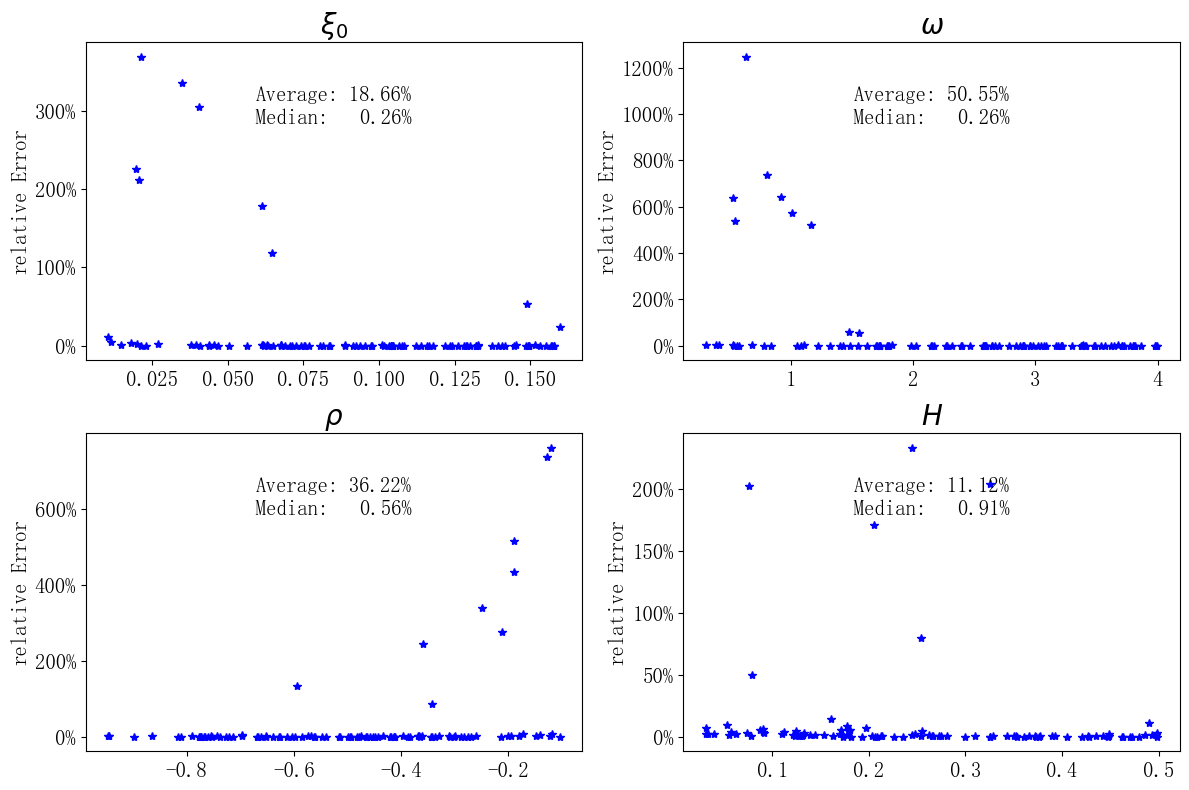

In [20]:
x_test_short = params_inv_scaler(x_test_transform[:100])

titles=["$\\xi_0$","$\\omega$","$\\rho$","$H$"]
average=np.zeros([4,100])
fig=plt.figure(figsize=(12,8))
for u in range(4):
    ax=plt.subplot(2,2,u+1)
    x=x_test_short[:,u]
    plt.plot(x,100*np.abs(Approx[:100,u]-x)/np.abs(x),'b*')
    average[u,:]=np.abs(Approx[:100,u]-x)/np.abs(x)
    
    plt.title(titles[u],fontsize=20)
    plt.ylabel('relative Error',fontsize=15)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.tick_params(axis='both', which='minor', labelsize=15)
    plt.text(0.5, 0.8, 'Average: %1.2f%%\n Median:   %1.2f%% '%(np.mean(100*average[u,:]),np.quantile(100*average[u,:],0.5)), horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize=15)
plt.tight_layout()
# plt.suptitle(f"{methods[0]}", fontsize=24, y=1.05)
plt.savefig('rBergomiParameterRelativeErrors.png', dpi=300)
plt.show();

(100, 88)